In [62]:
import math
import os
import random
import re
import shutil
from collections import Counter

import anndata
import cv2
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import seaborn as sns
import scipy
import scanpy as sc
from PIL import Image

from tensorflow.keras.models import Sequential
# import tensorflow_datasets as tfds
import tensorflow as tf
import tf_explain

import os
import numpy as np
import matplotlib.pyplot as plt



import pollock
import pollock.preprocessing.preprocessing as pollock_pp

In [2]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=120)
sc.settings.figdir = 'results/sandbox'

mpl.rcParams['pdf.fonttype'] = 42

scanpy==1.4.5.post3 anndata==0.7.1 umap==0.3.10 numpy==1.18.1 scipy==1.4.1 pandas==1.0.0 scikit-learn==0.22.1 statsmodels==0.11.0 python-igraph==0.7.1 louvain==0.6.1


## load in data and labels

In [3]:
adata = sc.read_loom('/Users/erikstorrs/Documents/ding/imaging/data/htan/single_cell/TWCE-HT061P1-S1PAA1A1Z1B1_processed_annotated.loom')
adata

/Users/erikstorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/loompy/loom_layer.py:123: RuntimeWarning: invalid value encountered in not_equal
  nonzeros = np.where(vals != 0)


AnnData object with n_obs × n_vars = 2131 × 19532 
    obs: 'ClusterID', 'ClusterName', 'SCT_snn_res_0_5', 'cell_type', 'nCount_RNA', 'nCount_SCT', 'nFeature_RNA', 'nFeature_SCT', 'orig_ident', 'percent_mito', 'seurat_clusters'
    var: 'Selected', 'detection_rate', 'gmean', 'residual_mean', 'residual_variance', 'variance'
    obsm: 'pca_cell_embeddings', 'umap_cell_embeddings'
    varm: 'pca_feature_loadings'
    layers: 'norm_data', 'scale_data'

In [4]:
adata.obsm['X_umap'] = adata.obsm['umap_cell_embeddings']
adata.obsm['X_pca'] = adata.obsm['pca_cell_embeddings']

... storing 'ClusterName' as categorical
... storing 'SCT_snn_res_0_5' as categorical
... storing 'cell_type' as categorical
... storing 'orig_ident' as categorical
... storing 'seurat_clusters' as categorical


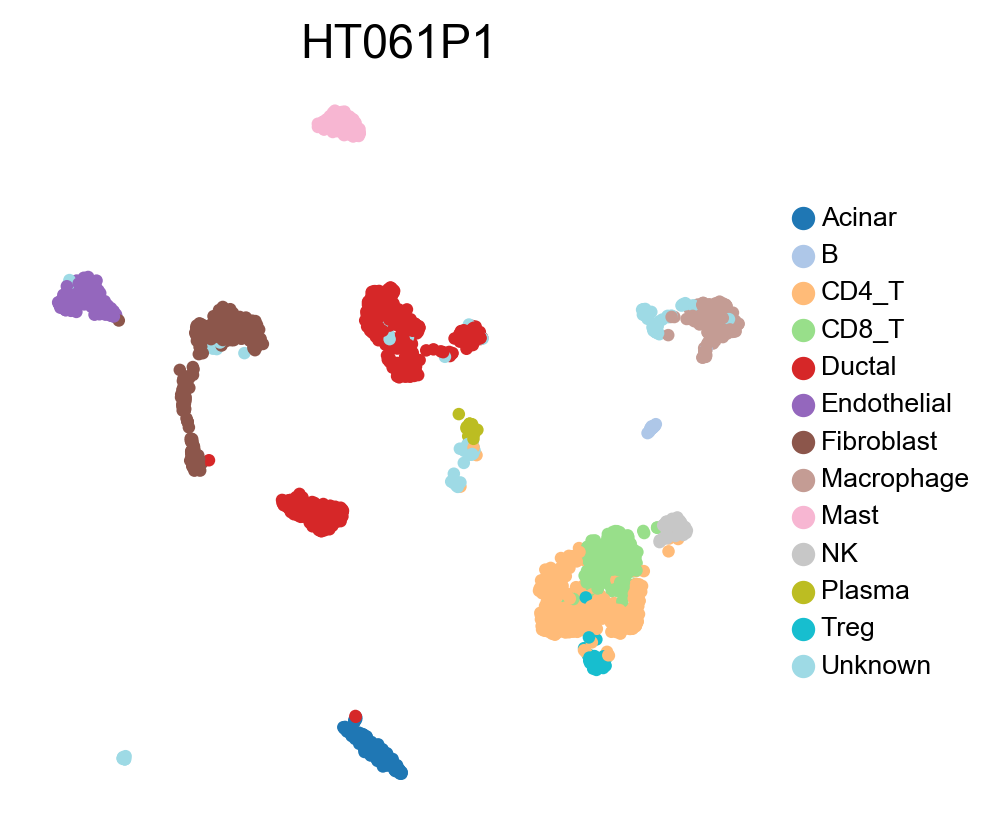

In [5]:
sc.pl.umap(adata, color=['ClusterName'], palette='tab20', frameon=False, title='HT061P1', legend_fontsize=8,
           save='HT061P1_umap.png')

In [6]:
## get rid of unknown
adata = adata[adata.obs['ClusterName']!='Unknown', :]
adata

View of AnnData object with n_obs × n_vars = 1991 × 19532 
    obs: 'ClusterID', 'ClusterName', 'SCT_snn_res_0_5', 'cell_type', 'nCount_RNA', 'nCount_SCT', 'nFeature_RNA', 'nFeature_SCT', 'orig_ident', 'percent_mito', 'seurat_clusters'
    var: 'Selected', 'detection_rate', 'gmean', 'residual_mean', 'residual_variance', 'variance'
    uns: 'ClusterName_colors'
    obsm: 'pca_cell_embeddings', 'umap_cell_embeddings', 'X_umap', 'X_pca'
    varm: 'pca_feature_loadings'
    layers: 'norm_data', 'scale_data'

In [7]:
c = Counter(adata.obs['ClusterName'])
c.most_common()

[('Ductal', 430),
 ('CD4_T', 361),
 ('Fibroblast', 285),
 ('CD8_T', 245),
 ('Macrophage', 146),
 ('Endothelial', 145),
 ('Mast', 117),
 ('Acinar', 108),
 ('NK', 67),
 ('Treg', 45),
 ('B', 21),
 ('Plasma', 21)]

## construct inputs

In [9]:
loaded_adata = anndata.AnnData(X=adata.X, obs=adata.obs[['ClusterName']], var=adata.var)
loaded_adata.obs.index = adata.obs.index
loaded_adata

AnnData object with n_obs × n_vars = 1991 × 19532 
    obs: 'ClusterName'
    var: 'Selected', 'detection_rate', 'gmean', 'residual_mean', 'residual_variance', 'variance'

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


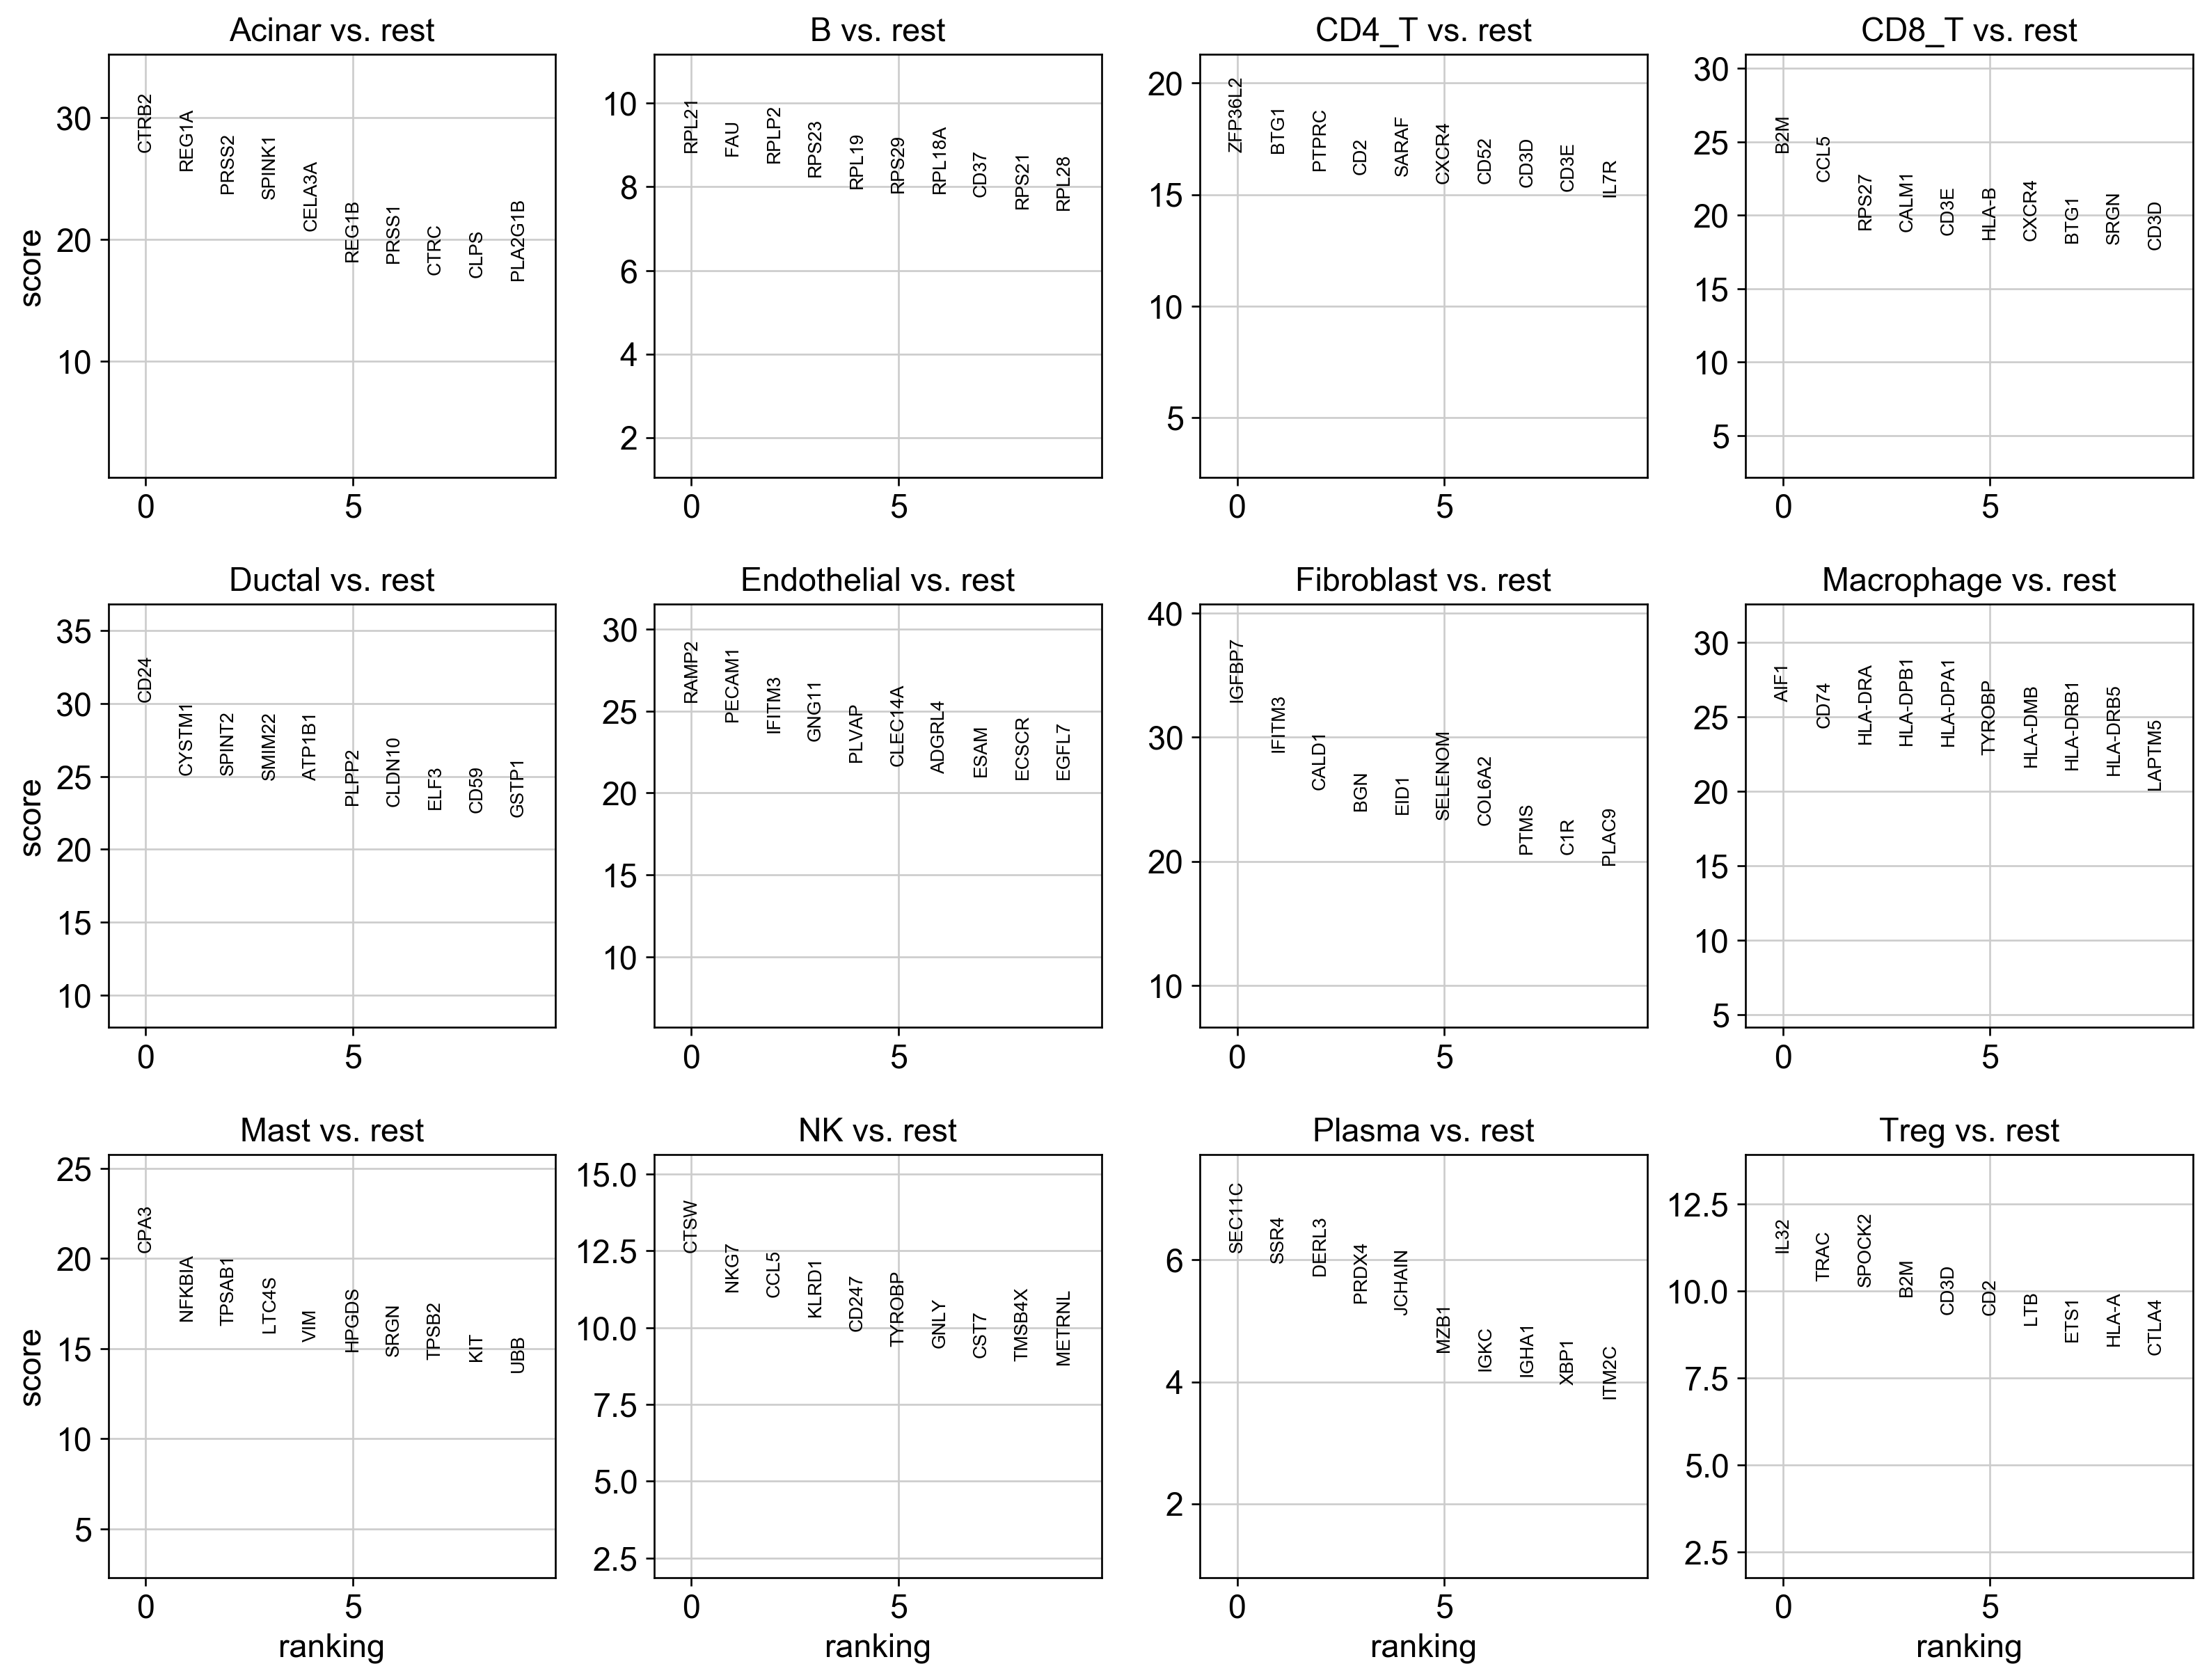

In [15]:
sc.tl.rank_genes_groups(loaded_adata, 'ClusterName', method='t-test', n_genes=1000)
sc.pl.rank_genes_groups(loaded_adata, n_genes=10, sharey=False)

In [ ]:
            r = int(index)
            c = int((index - r) * bs.shape[1])
            r = r * b.shape[0]

In [20]:
def get_row_and_col(location, overall_shape, block_shape):
    r = int(location)
    c = int((location - r) * overall_shape[1])
    r = r * block_shape[0]
    
    return r, c

def create_block_image_template(adata, key='ClusterName', block_shape=(4, 4), size=(128, 128)):
    n_genes = block_shape[0] * block_shape[1]
    sc.tl.rank_genes_groups(adata, key, method='t-test', n_genes=n_genes)
    ranked_genes_groups = adata.uns['rank_genes_groups']['names']
    cell_types = sorted(set(adata.obs[key]))
    
    total_pixels = size[0] * size[1]
    current_fraction = int(total_pixels / (4 * n_genes * len(cell_types)))
    expansions = int(math.log(current_fraction, 4)) + 1
    
    spots = np.power(4, expansions)
    block = np.full(size, '', dtype=object)
    cell_template = np.full(size, '', dtype=object)
    for i, cell_type in enumerate(cell_types):
        genes = ranked_genes_groups[cell_type]
        bs = np.full((block_shape[0] * int(np.sqrt(spots)), block_shape[1] * int(np.sqrt(spots))), '', dtype=object)
        for j, gene in enumerate(genes):
            
            b = np.full((spots,), gene).reshape((int(np.sqrt(spots)), int(np.sqrt(spots))))
            location = (j * b.shape[0]) / bs.shape[0]
            r, c = get_row_and_col(location, bs.shape, b.shape)
            bs[r:r + b.shape[0], c:c + b.shape[1]] = np.copy(b)
            
        
        location = (i * bs.shape[0]) / size[0]
        r, c = get_row_and_col(location, size, bs.shape)
        block[r:r + bs.shape[0], c:c + bs.shape[1]] = np.copy(bs)
        cell_template[r:r + bs.shape[0], c:c + bs.shape[1]] = np.full(bs.shape, cell_type, dtype=object)

    return block, cell_template
    
    

template, cell_template = create_block_image_template(loaded_adata)
    
template

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


array([['CTRB2', 'CTRB2', 'CTRB2', ..., 'CALM1', 'CALM1', 'CALM1'],
       ['CTRB2', 'CTRB2', 'CTRB2', ..., 'CALM1', 'CALM1', 'CALM1'],
       ['CTRB2', 'CTRB2', 'CTRB2', ..., 'CALM1', 'CALM1', 'CALM1'],
       ...,
       ['', '', '', ..., '', '', ''],
       ['', '', '', ..., '', '', ''],
       ['', '', '', ..., '', '', '']], dtype=object)

In [21]:
def get_expression_image(gene_to_expression, template):
    gene_img = np.full(template.shape, 0, dtype=int)
    for i in range(template.shape[0]):
        for j in range(template.shape[1]):
            gene_img[i, j] = gene_to_expression.get(template[i, j], 0) + 1
    return np.asarray(gene_img)

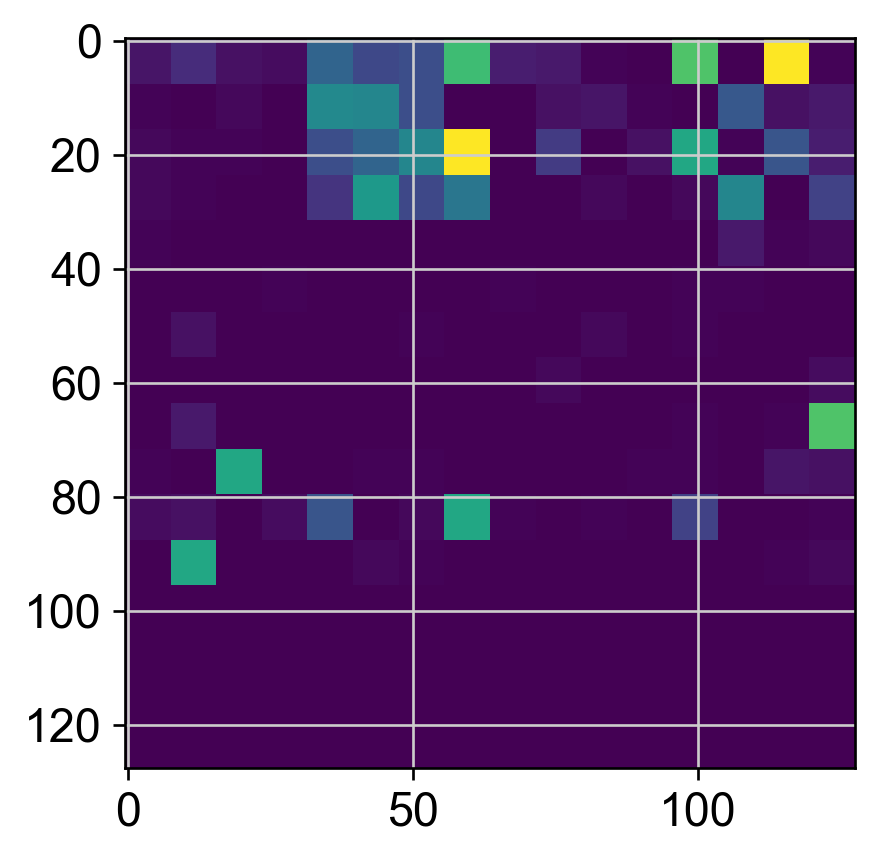

In [22]:
gene_to_expression = {g:e
        for g, e in zip(loaded_adata.var.index, np.asarray(loaded_adata.X[0, :].todense()).flatten())}
gene_img = get_expression_image(gene_to_expression, template)
plt.imshow(gene_img)

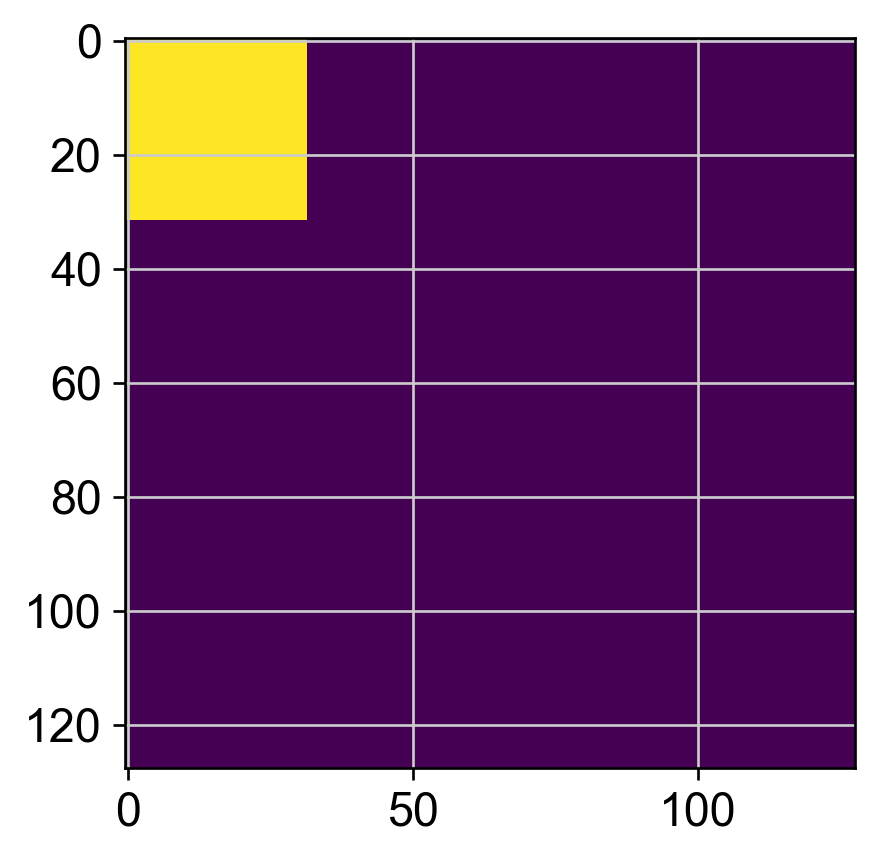

In [23]:
plt.imshow(cell_template=='Acinar')

In [ ]:
# !mkdir /Volumes/timmy/ding/pollock/01302020
!mkdir /Users/erikstorrs/Downloads/02032020

# results_dir = '/Volumes/timmy/ding/pollock/01302020'
results_dir = '/Users/erikstorrs/Downloads/02032020'


for x in ['training', 'validation', 'all']:
    os.mkdir(os.path.join(results_dir, x))
    
    for cell_type in set(adata.obs['cell_type']):
        os.mkdir(os.path.join(results_dir, x, cell_type))

In [146]:
def initialize_directories(cell_types, root='./temp_images'):
    if os.path.isdir(root):
        shutil.rmtree(root)
    
    os.mkdir(root)
    for x in ['training', 'validation', 'all']:
        if not os.path.isdir(os.path.join(root, x)):
            os.mkdir(os.path.join(root, x))

        for cell_type in sorted(set(cell_types)):
            if not os.path.isdir(os.path.join(root, x, cell_type)):
                os.mkdir(os.path.join(root, x, cell_type))
            
def write_images(adata, template, cell_type_key='ClusterName', root='./temp_images'):
    cell_type_to_fps = {}
    for i in range(adata.shape[0]):
        if i % 250 == 0: print(i)

        cell_type = adata.obs[cell_type_key][i]

        if cell_type not in cell_type_to_fps:
            cell_type_to_fps[cell_type] = []

        cell_id = adata.obs.index[i]
        gene_to_expression = {g:e
                for g, e in zip(adata.var.index, np.asarray(adata.X[i, :].todense()).flatten())}
        gene_img = get_expression_image(gene_to_expression, template)
#         plt.imshow(gene_img)
#         plt.show()
        gene_img = (gene_img / np.max(gene_img)) * 255
        gene_img = gene_img.astype(np.uint8)
        gene_img = np.moveaxis(np.asarray([gene_img, gene_img, gene_img]), 0, -1)
#         plt.imshow(gene_img)
#         plt.show()
#         raise RuntimeError()
        fp = os.path.join(root, 'all', cell_type, f'{cell_id}.jpg')
        cell_type_to_fps[cell_type].append(fp)

        mpl.image.imsave(fp, gene_img)
    return cell_type_to_fps
        
def setup_training(cell_type_to_fps, train_split=.8, n_per_cell_type=200):
    for cell_type, fps in cell_type_to_fps.items():
        split = int(len(fps) * train_split)
#         print(split, len(fps))

        training = fps[:split]
        validation = fps[split:]
#         print(validation[0], len(validation))

        choices = random.choices(training, k=n_per_cell_type)
        for i, fp in enumerate(choices):
            shutil.copy(fp,
                fp.replace(f'/all/{cell_type}/', f'/training/{cell_type}/').replace('.jpg', f'_{i}.jpg'))
        for fp in validation:
            shutil.copy(fp, fp.replace(f'/all/{cell_type}/', f'/validation/{cell_type}/'))

In [145]:
cell_types = sorted(set(adata.obs['ClusterName']))
img_dir = './temp_imgs'
initialize_directories(cell_types, root=img_dir)
cell_type_to_fps = write_images(loaded_adata, template, root=img_dir)
setup_training(cell_type_to_fps, n_per_cell_type=100)

0
250
500
750
1000
1250
1500
1750
288 361
./temp_imgs/all/CD4_T/TAAGTCGTCGTTAGAC-1.jpg 73
344 430
./temp_imgs/all/Ductal/TCATTGTCAGGTTCGC-1.jpg 86
228 285
./temp_imgs/all/Fibroblast/TCGAAGTCAAGCTGCC-1.jpg 57
196 245
./temp_imgs/all/CD8_T/TCATTACAGGTAGGCT-1.jpg 49
116 145
./temp_imgs/all/Endothelial/TATCTGTTCCGGTAAT-1.jpg 29
116 146
./temp_imgs/all/Macrophage/TCGAAGTGTTCTCAGA-1.jpg 30
16 21
./temp_imgs/all/B/GTGACGCGTCGTTGGC-1.jpg 5
53 67
./temp_imgs/all/NK/TCTCTGGGTATCGCTA-1.jpg 14
93 117
./temp_imgs/all/Mast/TCAAGTGGTGGCATCC-1.jpg 24
86 108
./temp_imgs/all/Acinar/TCCTCTTGTGCGTCGT-1.jpg 22
36 45
./temp_imgs/all/Treg/TTACCATCAACGATTC-1.jpg 9
16 21
./temp_imgs/all/Plasma/TCGTGCTTCACCATAG-1.jpg 5


## train model

In [147]:
PATH = img_dir
train_dir = os.path.join(PATH, 'training')
validation_dir = os.path.join(PATH, 'validation')

In [148]:
batch_size = 128
epochs = 10
IMG_HEIGHT = 128
IMG_WIDTH = 128

In [149]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
CLASS_NAMES = np.asarray(os.listdir(train_dir))
def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    return parts[-2] == CLASS_NAMES

def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    img = tf.image.convert_image_dtype(img, tf.float32)
    # resize the image to the desired size.
#     return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])
    return img

def process_path(file_path):
    label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
    # This is a small dataset, only load it once, and keep it in memory.
    # use `.cache(filename)` to cache preprocessing work for datasets that don't
    # fit in memory.
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    # Repeat forever
    ds = ds.repeat()

    ds = ds.batch(batch_size)

    # `prefetch` lets the dataset fetch batches in the background while the model
    # is training.
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

def get_dataset(fp, cache=True):
    list_ds = tf.data.Dataset.list_files(str(fp + '/*/*'))
    labeled_ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
    return prepare_for_training(labeled_ds, cache=cache)

In [150]:
train_ds = get_dataset(train_dir, cache=True)
val_ds = get_dataset(validation_dir, cache=True)

In [151]:
train_length = len(list(pollock_pp.listfiles(train_dir, regex='.jpg$')))
val_length = len(list(pollock_pp.listfiles(validation_dir, regex=r'.jpg$')))
train_length, val_length

(1200, 403)

In [152]:
model = Sequential([
    tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(.5),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(len(CLASS_NAMES), activation='softmax')
])

In [153]:
model.compile(
              optimizer=tf.keras.optimizers.Adam(learning_rate=.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [154]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 128, 128, 16)      448       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 64, 64, 32)        4640      
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 16384)            

In [155]:
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)]
# callbacks = []
history = model.fit(train_ds,
                    epochs=epochs,
                    steps_per_epoch=(train_length // batch_size) + 1,
                    validation_data=val_ds,
                    validation_steps=(val_length // batch_size) + 1,
                    callbacks=callbacks)

Train for 10 steps, validate for 4 steps
Epoch 1/10
10/10 [==============================] - 7s 687ms/step - loss: 1.0557 - accuracy: 0.6891 - val_loss: 0.8437 - val_accuracy: 0.7598
Epoch 2/10
10/10 [==============================] - 6s 566ms/step - loss: 0.2551 - accuracy: 0.9031 - val_loss: 0.6535 - val_accuracy: 0.7773
Epoch 3/10
10/10 [==============================] - 5s 547ms/step - loss: 0.1925 - accuracy: 0.9375 - val_loss: 0.3133 - val_accuracy: 0.8848
Epoch 4/10
10/10 [==============================] - 5s 546ms/step - loss: 0.1185 - accuracy: 0.9625 - val_loss: 0.2383 - val_accuracy: 0.9297
Epoch 5/10
10/10 [==============================] - 6s 561ms/step - loss: 0.0645 - accuracy: 0.9766 - val_loss: 0.2445 - val_accuracy: 0.9141
Epoch 6/10
10/10 [==============================] - 6s 554ms/step - loss: 0.0713 - accuracy: 0.9797 - val_loss: 0.2512 - val_accuracy: 0.9082


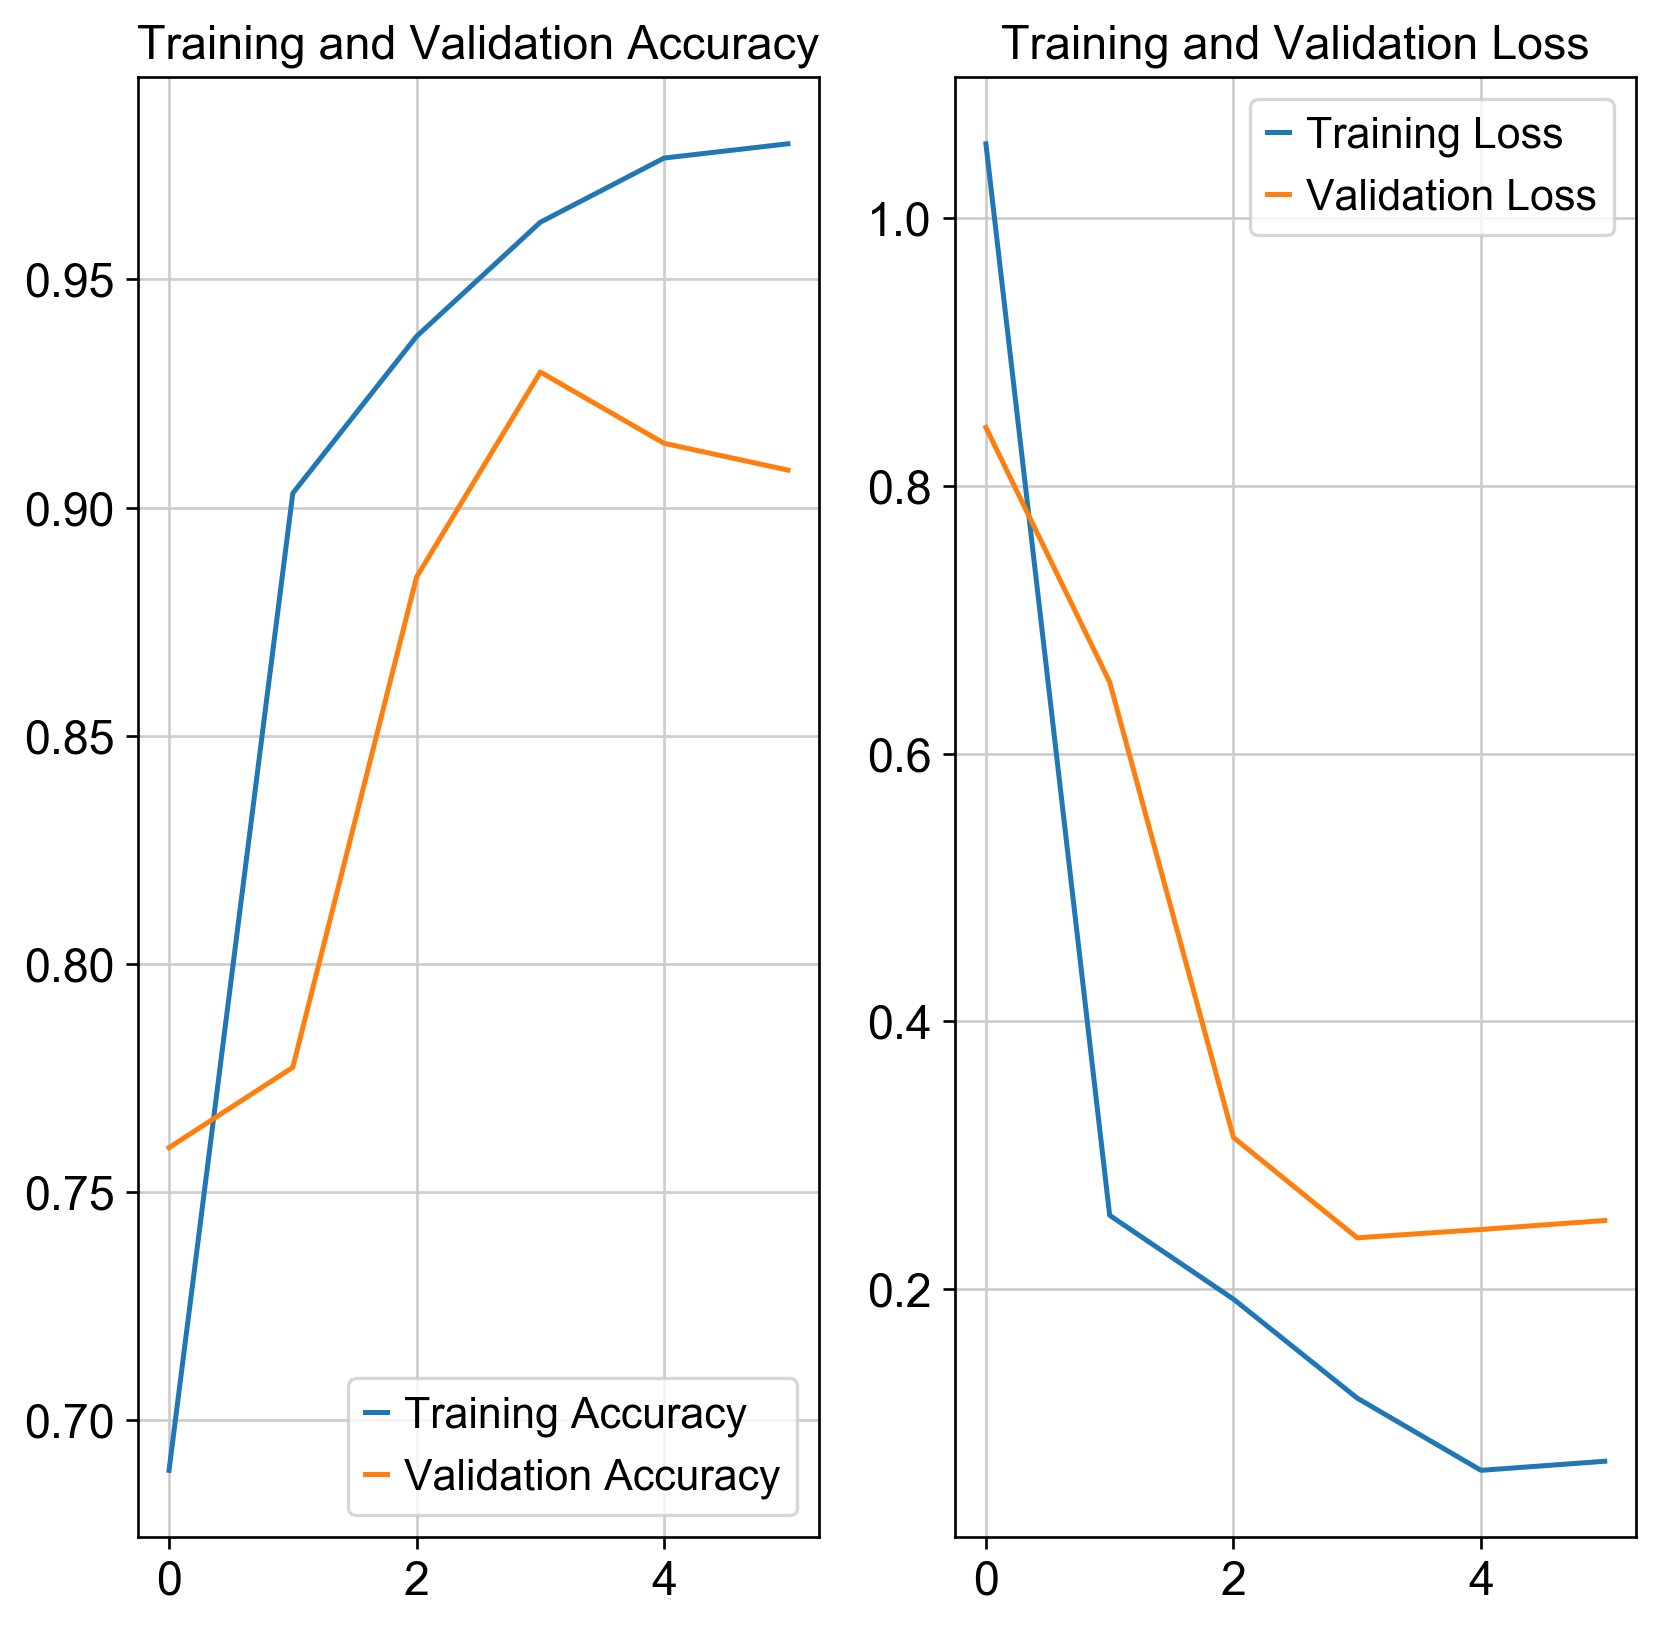

In [157]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(6)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [180]:
X, y = None, None
for images, labels in val_ds.take((val_length // batch_size) + 0):  # only take first element of dataset
    if X is None:
        X, y = images.numpy(), labels.numpy()
    else:
        X = np.concatenate((X, images.numpy()), axis=0)
        y = np.concatenate((y, labels.numpy()), axis=0)
y = np.argmax(y, axis=1)
X.shape, y.shape

((384, 128, 128, 3), (384,))

In [181]:
# predictions = model.predict_generator(val_ds, steps=(val_length // batch_size) + 1)
# predicted_labels = np.argmax(predictions, axis=1)
# predicted_labels
predictions = model.predict(X)
predicted_labels = np.argmax(predictions, axis=1)
predicted_labels

array([ 8,  4, 10, 10,  4,  8,  5,  3,  4,  4,  2,  5,  4,  4,  5, 10,  8,
        2,  3,  7,  4,  4,  5,  5,  4,  5,  8,  6,  5,  5,  8,  7,  5,  4,
        4,  4,  2,  4, 10, 10,  3,  8,  7,  5,  5,  7,  5,  8,  3,  7,  5,
        8,  8, 10, 10,  7,  7,  8,  5,  8,  4,  5,  8,  1,  7,  2,  4,  2,
       10,  2,  4,  8, 10,  3,  8,  5,  3,  3,  5,  3,  1, 10,  3, 10,  9,
        1, 10,  5,  6, 11, 10,  8,  4, 10,  4,  3,  5,  4,  6,  8,  4,  3,
       10,  4,  3,  2,  8,  4,  9,  3,  0, 10, 10,  4,  8, 10,  3,  1,  7,
        3,  4,  9,  7,  3,  8,  5,  5,  8,  4,  4,  3,  7, 10,  4, 10,  4,
        3,  9,  4,  0,  4,  2,  4,  4,  0,  9,  8,  2,  5,  6,  7,  8,  5,
        1,  1, 11,  2,  1,  5,  4,  7, 10,  5,  3,  9,  5,  4,  2,  4,  4,
        9,  5,  2,  1,  8, 10,  4,  8,  8, 10,  9,  9,  6,  4,  4,  2,  5,
        8,  5,  8,  5,  8,  4,  1,  8,  8,  5,  5, 10,  4,  7,  3,  2,  8,
        4,  5,  8,  4,  4, 10, 10,  9,  4,  1,  8, 10,  5, 10,  8, 10,  2,
        8,  4,  2,  6,  4

In [182]:
CLASS_NAMES
d = {c:i for i, c in enumerate(CLASS_NAMES)}
d

{'Plasma': 0,
 'Macrophage': 1,
 'Mast': 2,
 'Endothelial': 3,
 'Ductal': 4,
 'CD4_T': 5,
 'Treg': 6,
 'Acinar': 7,
 'Fibroblast': 8,
 'NK': 9,
 'CD8_T': 10,
 'B': 11}

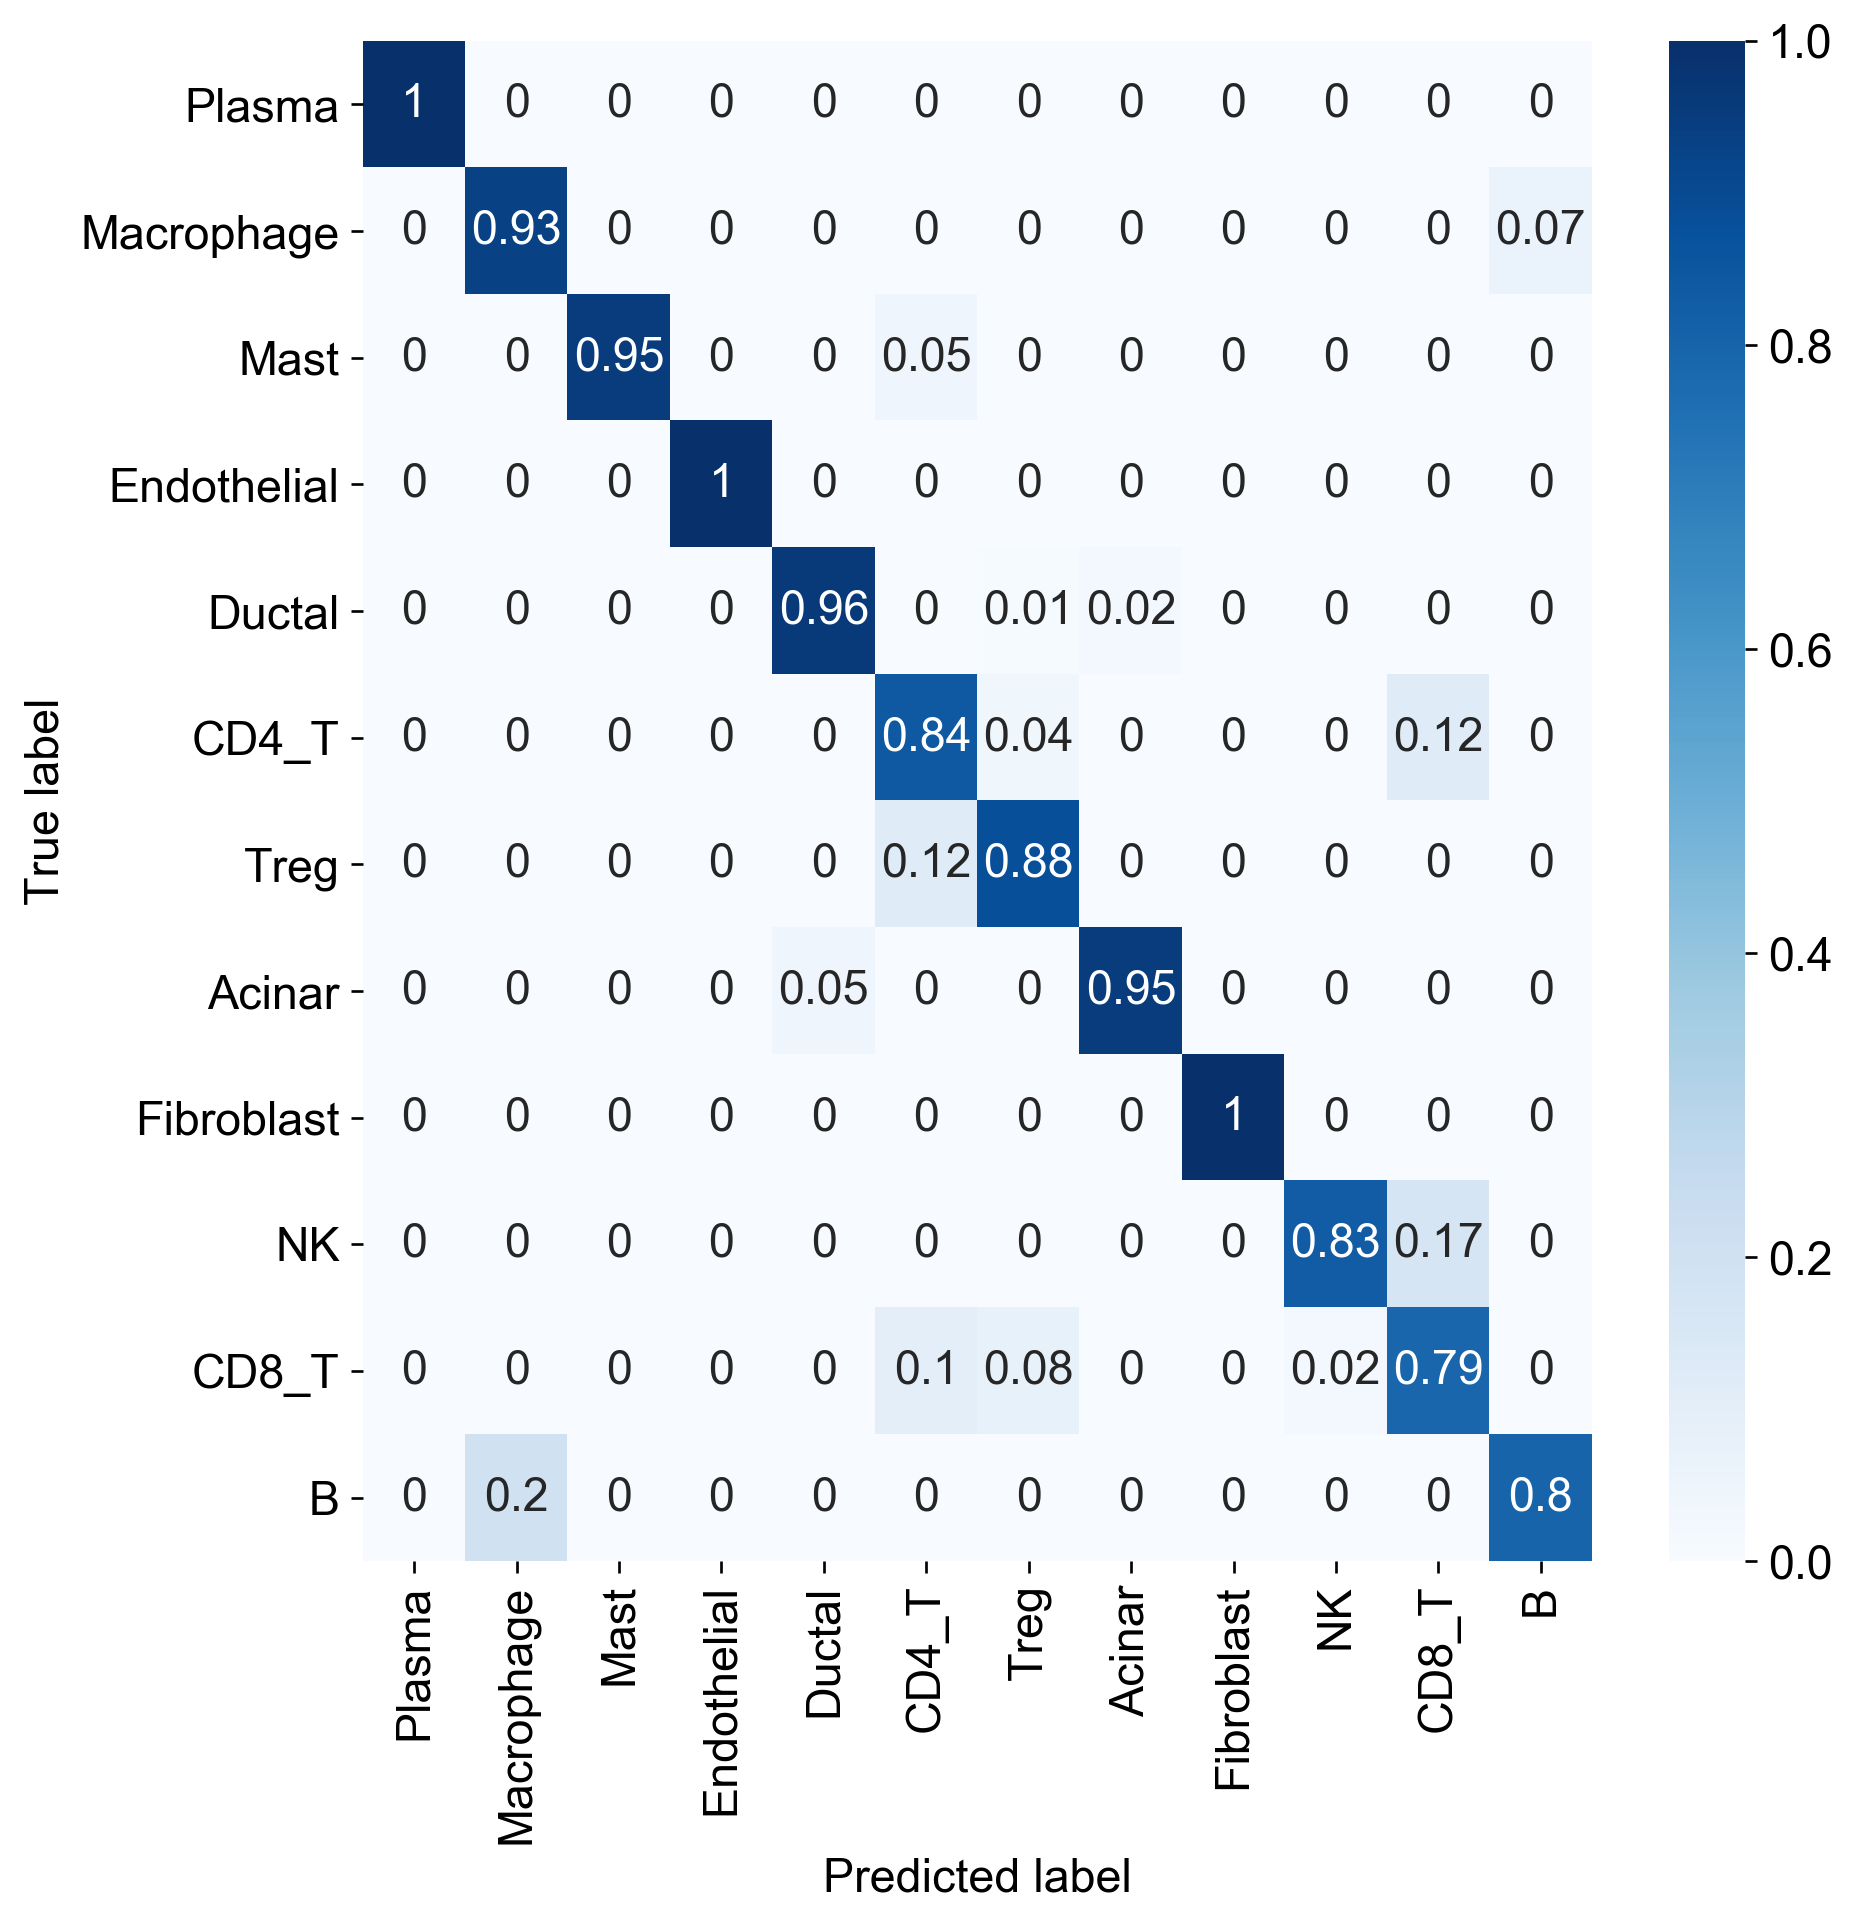

In [184]:
con_mat = tf.math.confusion_matrix(labels=y, predictions=predicted_labels).numpy()
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
classes = [k for k, v in sorted(d.items(), key=lambda x: x[1])]
con_mat_df = pd.DataFrame(con_mat_norm, index=classes, columns=classes)

figure = plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [185]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 128, 128, 16)      448       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 64, 64, 32)        4640      
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 16384)            

In [197]:
# intermediate_layer_model = tf.keras.Model(inputs=model.input,
#                                  outputs=model.get_layer('dense_14').output)
intermediate_layer_model = tf.keras.Model(inputs=model.input,
                                 outputs=model.get_layer(index=-2).output)
intermediate_output = intermediate_layer_model.predict(X)

In [198]:
intermediate_output.shape

(384, 512)

In [199]:
import umap
from sklearn.decomposition import PCA

embedding = PCA(20).fit_transform(intermediate_output)

reducer = umap.UMAP()

embedding = reducer.fit_transform(embedding)
embedding.shape

(384, 2)

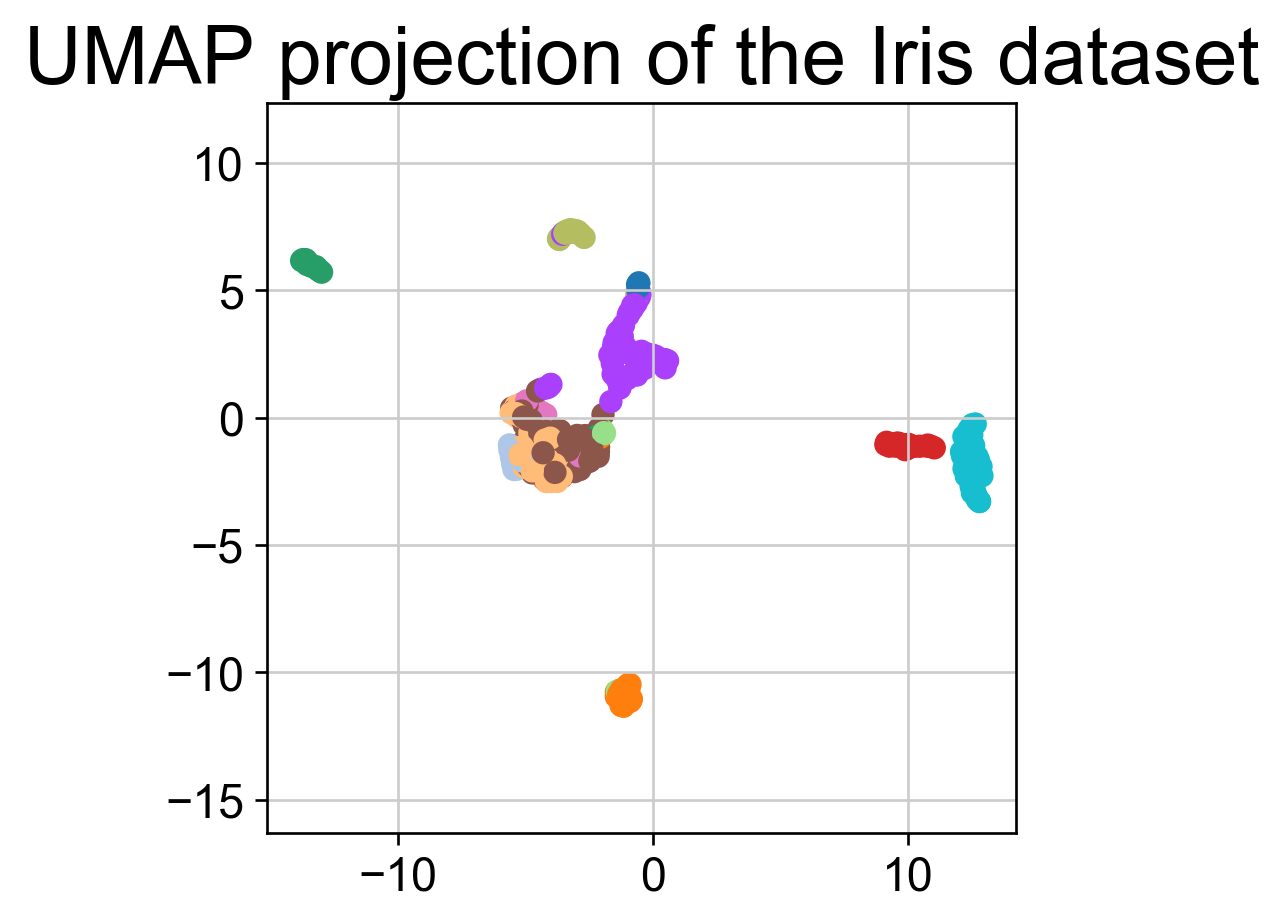

In [200]:
plt.scatter(embedding[:, 0], embedding[:, 1], c=[sns.color_palette()[x] for x in y])
plt.gca().set_kkkkaspect('equal', 'datalim')
plt.title('UMAP projection of the Iris dataset', fontsize=24);

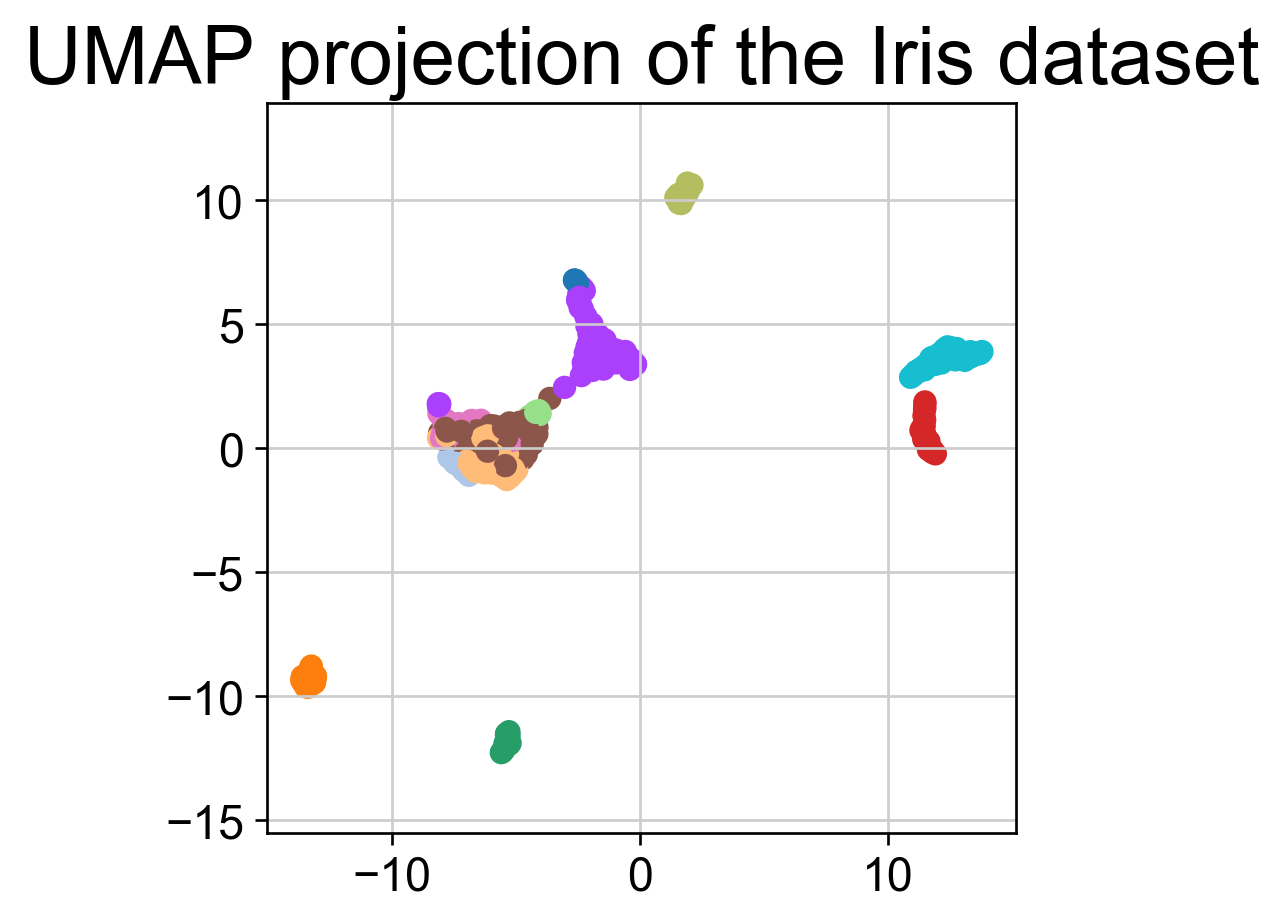

In [196]:
plt.scatter(embedding[:, 0], embedding[:, 1], c=[sns.color_palette()[x] for x in predicted_labels])
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the Iris dataset', fontsize=24);